In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
import seaborn as sns

In [2]:
# Read it in.
post = pd.read_excel('../data/postscndryunivsrvy2013dirinfo_cut.xlsx')
peps = pd.read_excel('../data/peps300.xlsx')

# Do some fixing and plumbing
post['OPEID_CLEAN'] = [value[2:] for value in post['OPEID_CLEAN'].values]
peps['OPEID_CLEAN'] = [str(value) for value in peps['OPEID_CLEAN'].values]

# Do some more plumbing.
peps = peps.iloc[:, :20]

# Merge our datasets.
joined = pd.merge(post, peps, on='OPEID_CLEAN')

/Users/danny/miniconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


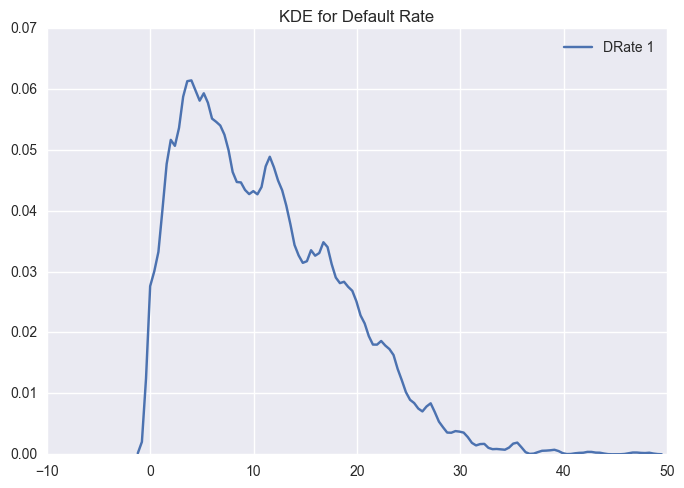

In [3]:
# ASK BRIAN:
#  CBSA: population density measure
#    CBSATYPE
#    CSA
#  Congressional district

# Not including geo-location features like zip code, county.
# TODO: revisit Latitude and Longitude for visualization.

features = ['UNITID',
            'CONTROL',
            'GROFFER',
            'HBCU',
            'HLOFFER',
            'HOSPITAL',
            'ICLEVEL',
            'INSTCAT',
            'INSTSIZE',
            'LANDGRNT', # Revisit
            'LOCALE',
            'PSEFLAG',
            'SECTOR',
            'Prog\nLength',
            'School\nType',
#             '\nDenom 1',
#             '\nNum 1',
            'DRate 1',
            'Ethnic Code',
            'Average or\nGreater than 30']

med = np.median(joined['DRate 1'])

ax = plt.axes()
ax.set_title("KDE for Default Rate")
kde = sns.kdeplot(joined['DRate 1'], bw = 0.4)
fig = kde.get_figure()
fig.savefig("kde_plot.png")

In [4]:
# Master dataset!!
joined = joined[features]

# np.median(joined['DRate 1']) == 9.80000
med = np.median(joined['DRate 1'])

joined['DRate_Transformed'] = joined['DRate 1'] > med
joined['DRate_Transformed'] = joined['DRate_Transformed'].astype(int)

# TODO eventually re-add this statement
# joined = joined.drop('DRate 1', axis = 1)

In [5]:
# Our initial model works with THIS dataset.
joined.to_csv("../data/peps_to_post.csv", index=False)

In [6]:
ipeds = pd.read_csv("../data/delta_public_00_12.csv", encoding="ISO-8859-1")

/Users/danny/miniconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
ipeds['is_2012'] = ipeds['academicyear'] == 2012
ipeds = ipeds[ipeds['is_2012']]

In [8]:
# REMOVE instname, unitid WHEN DONE

ipeds_features ="""
instname
unitid
sector
iclevel
control
census_region
hbcu
hsi
cpi_index
hepi_index
has_fte
nettuition01
net_student_tuition
endowment03
priv_invest_endow
total03_revenue
restricted_revenue
grant01
grant02
grant07
tuition_discount
institutional_grant_aid_share
fed_grant_pct
inst_grant_pct
loan_pct
loan_avg_amount
inst_grant_avg_amount
tuitionfee02_tf
studserv01
acadsupp01
sticker_price_share
nettuition_share
totaldegrees_100fte
certificates_awards_100fte
totalcompletions_100fte
ft_first_time_first_yr_deg_seek
total_full_time
total_enrollment_asian_tot
total_enrollment_black_tot
total_enrollment_hisp_tot
total_enrollment_white_tot
ft_faculty_per_100fte
pt_faculty_per_100fte
salarytotal""".split()

# Isolate wanted columns, map column headers to uppercase for join.
ipeds = ipeds[ipeds_features]
ipeds.columns = map(str.upper, ipeds.columns)

In [9]:
# Merge :joined and :ipeds on the UNITID column.
master = pd.merge(joined, ipeds, on="UNITID")

In [10]:
# Set our institution's UNITID to be its index, drop
# the corresponding UNITID column.
master.index = master['UNITID']
master = master.drop("UNITID", axis = 1)

# Leave this here please :)
master_copy = master
master_copy.index = master_copy['INSTNAME']
master_copy = master_copy.drop("INSTNAME", axis = 1)

In [11]:
# Master dataset! Woo.
master.to_csv("../data/master.csv")

In [12]:
pd.isnull(master).any()
nans = pd.isnull(master)
nans_copy = pd.isnull(master_copy)

from collections import Counter

university_nans = Counter()
column_count_nans = Counter()

for index, row in zip(nans_copy.index, nans_copy.values):
    row_data = dict(zip(nans_copy.columns.values, row))

    for column, value in row_data.items():
        if value:
            university_nans[index] += 1
            column_count_nans[column] += 1

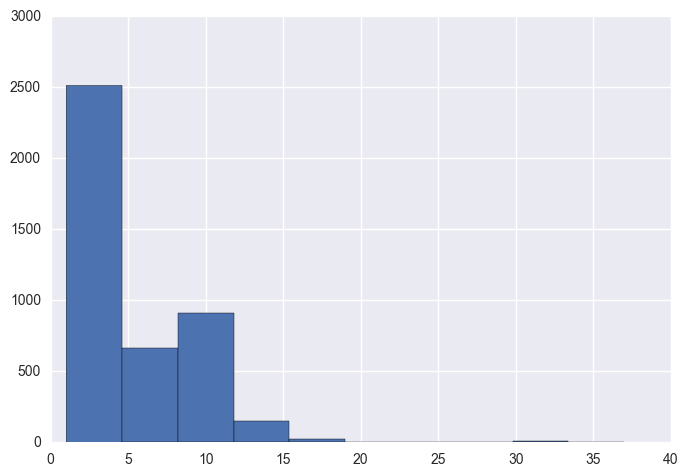

In [13]:
# A good number of our institutions have between 0 and 10 NaN values.
university_nan_dist = pd.DataFrame.from_dict(university_nans, orient='index').reset_index()
university_nan_dist = university_nan_dist.rename(columns={'index':'event', 0:'count'})
plt.hist(university_nan_dist['count'])
plt.show()

In [14]:
column_nan_dist = pd.DataFrame.from_dict(column_count_nans, orient='index').reset_index()
column_nan_dist = column_nan_dist.rename(columns={'index':'event', 0:'count'})
column_nan_dist['count'] = column_nan_dist['count'].astype(int)

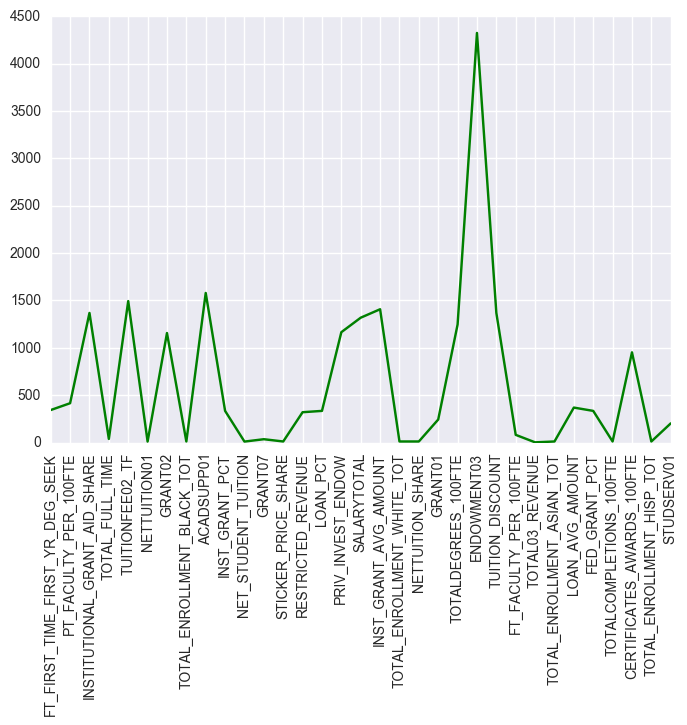

In [15]:
# Plot new features against their NaN count

fig, ax = plt.subplots()
x = range(len(column_nan_dist['event']))
plt.xticks(x, column_nan_dist['event'])
ax.set_xticklabels(column_nan_dist['event'], rotation = 90)
plt.plot(x, column_nan_dist['count'], "g")
plt.show()

In [16]:
master = master.drop('ENDOWMENT03', axis = 1)

In [17]:
# Isolate rows where master contains no missing values
not_nans = master.dropna(axis=0)

In [18]:
# Get percent of valid rows in master
valid_percent_of_master = 1 - (master.shape[0] - not_nans.shape[0]) / master.shape[0]
valid_percent_of_master

0.31706753006475485

/Users/danny/miniconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


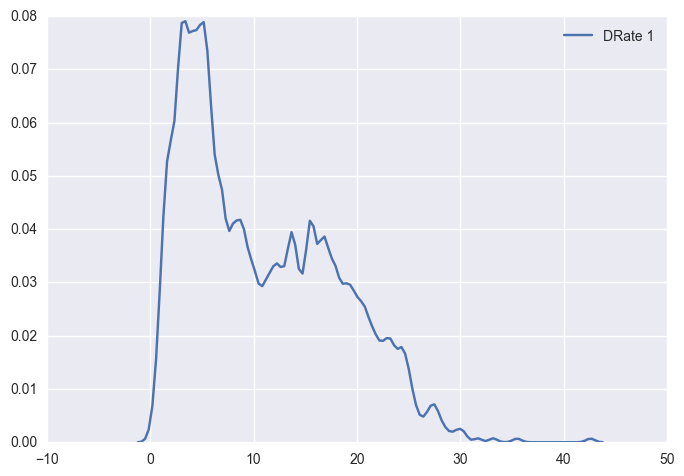

In [19]:
# Plot new default rate based on just the valid rows after dropping ENDOWMENT03
ax.set_title("KDE for Default Rate")
kde = sns.kdeplot(not_nans['DRate 1'], bw = 0.4)

In [20]:
# Get the distribution median for this non-null dataset.
# Note that the median declined from 9.8 to 9.2
np.median(not_nans['DRate 1'])

9.1999999999999993